# Part 2: Work with the Davis.csv dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import seaborn as sns
import math
import sklearn.linear_model as lm
import sklearn.metrics as mt 
from statsmodels.formula.api import ols
import os
# os.chdir('C:/Users/User/Desktop/BUS 705 - Statistics and Programming for BA/HW/Final Project')

## 1. Fitting Normals to the male heights

In [2]:
hwdata = pd.read_csv('Davis.csv')
hwdata.head()
# hwdata.describe()

,Unnamed: 0,sex,weight,height,reportedWeight,reportedHeight
0,1,M,77,182,77.0,180.0
1,2,F,58,161,51.0,159.0
2,3,F,53,161,54.0,158.0
3,4,M,68,177,70.0,175.0
4,5,F,59,157,59.0,155.0


In [3]:
male_heights = hwdata.loc[hwdata['sex'] == 'M', 'height'] * 0.393701
male_heights.describe()

count    88.000000
mean     70.083252
std       2.535710
min      64.173263
25%      68.110273
50%      70.078778
75%      72.047283
max      77.559097
Name: height, dtype: float64

In [4]:
# Fit a Normal distribution to the male heights
mean_MH, sd_MH  = st.norm.fit(male_heights)
print("Mean: %f, Standard error: %f " % (mean_MH, sd_MH))

Mean: 70.083252, Standard error: 2.521262 


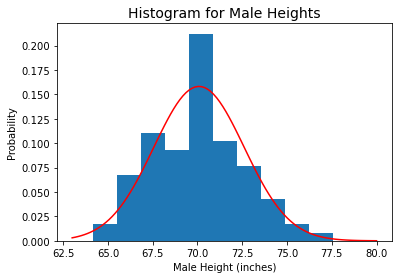

In [5]:
x = np.linspace(63, 80, 100)
fit_norm = st.norm.pdf(x, mean_MH, sd_MH)

# Plot a histogram with the density function 
plt.hist(male_heights, density=True)
plt.plot(x, fit_norm, 'r-')
plt.xlabel('Male Height (inches)')
plt.ylabel('Probability')
plt.title('Histogram for Male Heights', fontsize=14)
plt.show()

In [6]:
# The probability of a male being taller than 6 ft based on the estimates: 0.223557
prob_norm = 1 - st.norm.cdf(6*12, mean_MH, sd_MH)
print("The probability of a male being taller than 6 ft based on the estimates: %f " % prob_norm)

The probability of a male being taller than 6 ft based on the estimates: 0.223557 


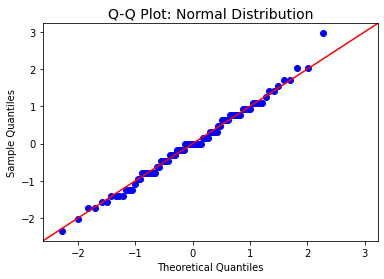

In [7]:
# Q-Q plot 
sm.qqplot((male_heights-mean_MH)/sd_MH, line ='45')
plt.title('Q-Q Plot: Normal Distribution', fontsize=14)
plt.show() 
# The fitting is appropriate since the points seem to fall about a straight line.
# The assumption that male heights follow a Normal distribution is adequate.

## 2. Fitting Gammas to the female weights

In [8]:
female_weights = hwdata.loc[hwdata['sex'] == 'F', 'weight'] * 2.2046
female_weights.describe()

count    112.000000
mean     125.425993
std       15.122251
min       85.979400
25%      116.292650
50%      123.457600
75%      136.685200
max      171.958800
Name: weight, dtype: float64

In [9]:
# Fit a Gamma distribution to the female weights
fit_alpha, fit_loc, fit_beta_inv = st.gamma.fit(female_weights, floc=0)   # mean = fit_alpha * fit_beta_inv
print("Alpha(shape): %f, Inverse Beta(scale): %f " % (fit_alpha, fit_beta_inv))

Alpha(shape): 70.165990, Inverse Beta(scale): 1.787561 


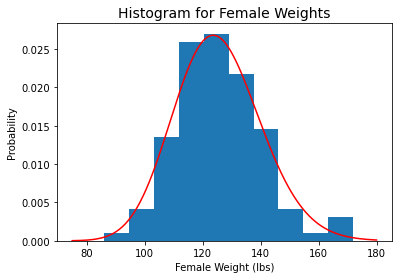

In [10]:
x = np.linspace(75,180,300)
fit_gamma = st.gamma.pdf(x, fit_alpha, fit_loc, fit_beta_inv)

# Plot a histogram with the density function 
plt.hist(female_weights, density=True)
plt.plot(x, fit_gamma, 'r-')
plt.xlabel('Female Weight (lbs)')
plt.ylabel('Probability')
plt.title('Histogram for Female Weights', fontsize=14)
plt.show()

In [11]:
# The probability of a female being lighter than 100 lbs based on the estimates: 0.036879 
prob_gamma = st.gamma.cdf(100, fit_alpha, fit_loc, fit_beta_inv)
print("The probability of a female being lighter than 100 lbs based on the estimates: %f " % prob_gamma)

The probability of a female being lighter than 100 lbs based on the estimates: 0.036879 


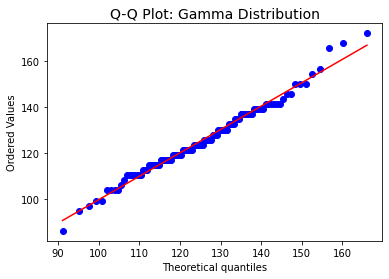

In [12]:
# Q-Q plot 
st.probplot(female_weights, dist=st.gamma, sparams=(fit_alpha, fit_loc, fit_beta_inv), plot=plt)
plt.title('Q-Q Plot: Gamma Distribution', fontsize=14)
plt.show()
# The fitting is appropriate since the points seem to fall about a straight line.
# The assumption that female weights follow a Gamma distribution is adequate.

## 3. Inference

In [13]:
# 95% confidence interval for the average female weight - classical statistical inference: (122.63784, 128.21414)
mu_hat = np.mean(female_weights)
sigma_hat = np.std(female_weights)
CI_avg_trad = (mu_hat - 1.96 * sigma_hat/math.sqrt(len(female_weights)), 
               mu_hat + 1.96 * sigma_hat/math.sqrt(len(female_weights)))
print("95% C.I. for the average female weight using classical statistical inference:", CI_avg_trad)

95% C.I. for the average female weight using classical statistical inference: (122.63784381360266, 128.2141419006831)


In [14]:
# 95% confidence interval for the average female weight - bootstrapping: (122.61119, 128.51686)
np.random.seed(42)
rep = 1000
mus = []
for i in range(0, rep):
    mu_sample = np.mean(np.random.choice(female_weights, size=len(female_weights), replace=True))
    mus = np.append(mus, mu_sample)

CI_avg_bt = (np.quantile(mus, .025), np.quantile(mus, .975))
print("95% C.I. for the average female weight using bootstrapping:", CI_avg_bt)

95% C.I. for the average female weight using bootstrapping: (122.61119107142859, 128.51686174107144)


In [15]:
# 95% confidence interval for the median female weight - bootstrapping: (122.253, 126.7645)
np.random.seed(42)
rep = 1000
meds = []
for i in range(0, rep):
    med_sample = np.median(np.random.choice(female_weights, size=len(female_weights), replace=True))
    meds = np.append(meds, med_sample)

CI_med_bt = (np.quantile(meds, .025), np.quantile(meds, .975))
print("95% C.I. for the median female weight using bootstrapping:", CI_med_bt)

95% C.I. for the median female weight using bootstrapping: (121.253, 126.76450000000001)


## 4. Bayesian Estimation

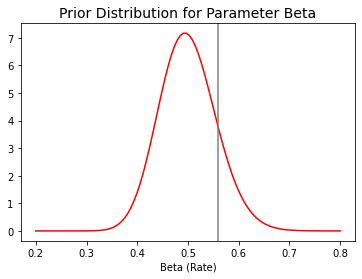

In [16]:
# Fix alpha
alpha = fit_alpha
xes = np.linspace(0.2, 0.8, 100)
alpha_0 = 80
beta_0 = 160
scale_0 = 1/beta_0

# Prior distribution for the second parameter beta
gammaprobs = st.gamma.pdf(xes, alpha_0, 0, scale_0)
plt.plot(xes, gammaprobs, 'r-')
plt.axvline(x=1/fit_beta_inv, color='grey')
plt.xlabel('Beta (Rate)')
plt.title('Prior Distribution for Parameter Beta', fontsize=14)
plt.show()

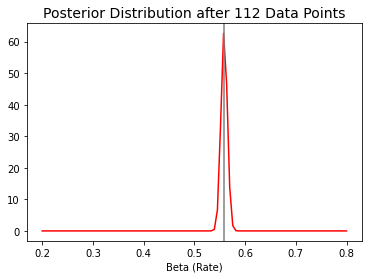

In [17]:
# Bayesian posterior after 112 data points
alpha_0_posterior = alpha_0 + (len(female_weights)*alpha)
beta_0_posterior = beta_0 + sum(female_weights)
scale_0_posterior = 1/beta_0_posterior

gammaprobs4 = st.gamma.pdf(xes, alpha_0_posterior, 0, scale_0_posterior)
plt.plot(xes, gammaprobs4, 'r-')
plt.axvline(x=1/fit_beta_inv, color='grey')
plt.xlabel('Beta (Rate)')
plt.title('Posterior Distribution after 112 Data Points', fontsize=14)
plt.show()

In [18]:
# The expected posterior mean and the posterior standard deviation of parameter beta
pos_mean = alpha_0_posterior * scale_0_posterior  
pos_sd = math.sqrt(alpha_0_posterior) * scale_0_posterior 
print("The expected posterior mean of parameter beta:", pos_mean)
print("The expected posterior standard deviation of parameter beta:", pos_sd)

The expected posterior mean of parameter beta: 0.5587522729835279
The expected posterior standard deviation of parameter beta: 0.006271155809039826


In [19]:
# 95% confidence interval for the average female weight using posterior: (125.31572, 125.83777)

# 95% C.I. for posterior
CI_beta_pos = (pos_mean - 1.96 * pos_sd/math.sqrt(len(female_weights)), 
               pos_mean + 1.96 * pos_sd/math.sqrt(len(female_weights)))
CI_avg_pos = (alpha / CI_beta_pos[1], alpha / CI_beta_pos[0])
print("95% C.I. for the average female weight using posterior:", CI_avg_pos)

95% C.I. for the average female weight using posterior: (125.31572187783893, 125.83777485569685)


In [20]:
# Compare the results from classical inference and Bayesian inference.
print("The posterior distribution is concentrated around the frequentist estimate.")
print("The expected Bayesian posterior mean %f is similar to frequentist estimate %f. " % (pos_mean, 1/fit_beta_inv))

The posterior distribution is concentrated around the frequentist estimate.
The expected Bayesian posterior mean 0.558752 is similar to frequentist estimate 0.559421. 


## 5. Multivariate Statistics

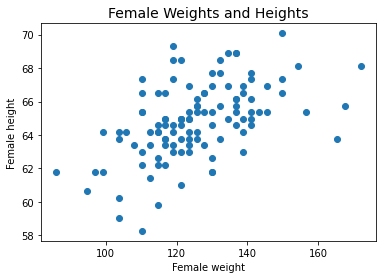

In [21]:
# Prepare a scatter plot between heights and weights for females.
female_weights = hwdata.loc[hwdata['sex'] == 'F', 'weight'] * 2.2046
female_heights = hwdata.loc[hwdata['sex'] == 'F', 'height'] * 0.393701
df_female = pd.DataFrame({'female_weights':female_weights,'female_heights':female_heights})

plt.scatter(female_weights, female_heights)
plt.xlabel('Female weight')
plt.ylabel('Female height')
plt.title('Female Weights and Heights', fontsize=14)
plt.show()

In [22]:
# Evaluate and illustrate the covariance and correlation matrices between heights and weights for females.
sigma = df_female.cov()  # covariance matrix
rho = df_female.corr()   # correlation matrix
print("covariance matrix: \n", sigma)
print("\ncorrelation matrix: \n", rho)

covariance matrix: 
                 female_weights  female_heights
female_weights      228.682481       17.308797
female_heights       17.308797        4.964005

correlation matrix: 
                 female_weights  female_heights
female_weights        1.000000        0.513729
female_heights        0.513729        1.000000


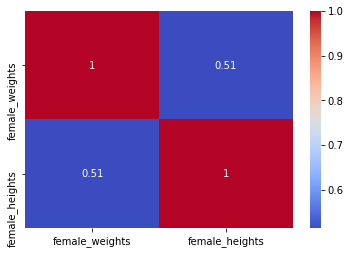

In [23]:
# Correlation plot
cor_plot = sns.heatmap(rho, annot = True, cmap= 'coolwarm')
# If a female is relatively tall, generally this person also tends to be heavier. 
# (heights and weights are positively associated)

In [24]:
# Consider the full data set for females. Evaluate and illustrate the covariance and correlation matrices.
df_female_all = hwdata.loc[hwdata['sex'] == 'F', ['weight','height','reportedWeight','reportedHeight']] 
df_female_all = df_female_all.dropna()  # remove missing data
sigma_all = df_female_all.cov()  # covariance matrix
rho_all = df_female_all.corr()   # correlation matrix
print("covariance matrix: \n", sigma_all)
print("\ncorrelation matrix: \n", rho_all)

covariance matrix: 
                    weight     height  reportedWeight  reportedHeight
weight          47.442383  18.875490       44.482993       19.164193
height          18.875490  30.211090       19.517007       29.919295
reportedWeight  44.482993  19.517007       45.612245       19.275510
reportedHeight  19.164193  29.919295       19.275510       33.539889

correlation matrix: 
                   weight    height  reportedWeight  reportedHeight
weight          1.000000  0.498576        0.956247        0.480426
height          0.498576  1.000000        0.525762        0.939912
reportedWeight  0.956247  0.525762        1.000000        0.492815
reportedHeight  0.480426  0.939912        0.492815        1.000000


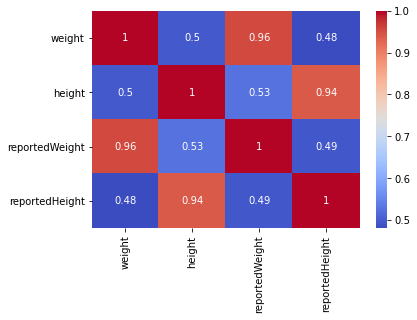

In [25]:
# Correlation plot
cor_plot_all = sns.heatmap(rho_all, annot = True, cmap= 'coolwarm')
# Reported height/weight are closely positively related, 
# whereas the height and weight pairs have a medium positive relationship.

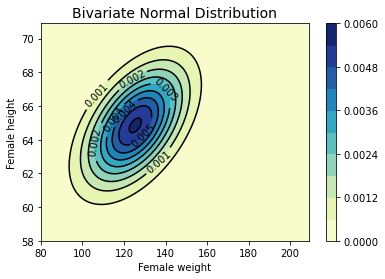

In [26]:
# Fit a bi-variate normal model to the female height-weight data. Illustrate the fit. 
weight_points = np.arange(80, 210)
height_points = np.arange(58, 71, 0.1)
w, h = np.meshgrid(weight_points, height_points)        # generate grid
zf = np.zeros((len(weight_points), len(height_points))) # pdf(w, h)

# Parameters of the multivariate normal distribution
mean_bi = np.array([np.mean(female_weights), np.mean(female_heights)])   # mean
cov_bi = np.cov(female_weights, female_heights)                          # covariance

# Fill the matrix for each combination of weight and height
for i in range(0,len(weight_points)):
    for j in range(0,len(height_points)):
        zf[i,j] = st.multivariate_normal.pdf(np.matrix([w[i,j], h[i,j]]), mean=mean_bi, cov=cov_bi)

# Plot a bivariate normal distribution   
cf = plt.contourf(w, h, zf, 10, cmap=plt.cm.YlGnBu)
c = plt.contour(w, h, zf, 10, colors='black')
plt.clabel(c, inline=True, fontsize=10)
plt.colorbar(cf)
plt.xlabel('Female weight')
plt.ylabel('Female height')
plt.title('Bivariate Normal Distribution', fontsize=14)
plt.show()      

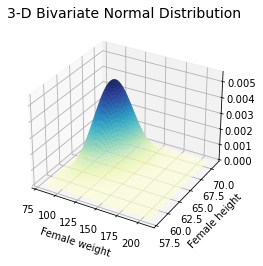

In [27]:
# 3-D bivariate normal distribution 
ax = plt.axes(projection='3d')
# ax.contour3D(w, h, zf, 100, cmap=plt.cm.YlGnBu)
ax.plot_surface(w, h, zf, rstride=1, cstride=1, cmap=plt.cm.YlGnBu)
ax.set_xlabel('Female weight')
ax.set_ylabel('Female height')
ax.set_title('3-D Bivariate Normal Distribution', fontsize=14)
plt.show()

## 6. Regression Analysis

In [28]:
# Run a regression of female heights (y) on female weight (x)
regr = lm.LinearRegression()
x = df_female[['female_weights']]
y = df_female['female_heights']
lmfit = regr.fit(x, y)
y_pred = lmfit.predict(x)
print('Coefficients: %.4f' % lmfit.coef_[0])
print('Intercept: %.4f' % lmfit.intercept_)
print('Coefficient of determination R^2 of the prediction.: %.3f' % lmfit.score(x, y))
print('Mean squared error: %.3f' % mt.mean_squared_error(y, y_pred))

Coefficients: 0.0757
Intercept: 55.3548
Coefficient of determination R^2 of the prediction.: 0.264
Mean squared error: 3.621


In [29]:
# Interpret the regression results
lmfit2 = ols(formula="female_heights ~ female_weights", data=df_female).fit() # OLS for better summary
print(lmfit2.summary())

                            OLS Regression Results                            
Dep. Variable:         female_heights   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     39.44
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           6.92e-09
Time:                        01:53:08   Log-Likelihood:                -230.98
No. Observations:                 112   AIC:                             466.0
Df Residuals:                     110   BIC:                             471.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         55.3548      1.523     36.

* Interpretation of results
1. The positive coefficient of female weight indicates that if a female is relatively heavy, generally this person also tends to be taller.
2. The R-squared value of 0.264 implies that around 26% of variation in female height is explained by this linear regression model.
3. The p-value of 0.000 for female weight indicates that the effect of female weight on female height is statistically significant (p-value < significance level of 0.05).

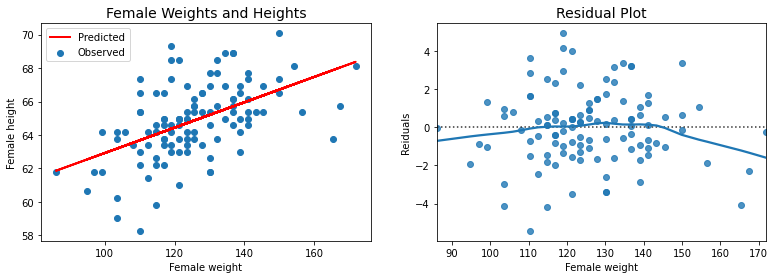

In [30]:
# Plot linear regression line
f1 = plt.figure(figsize=(13,4))
ax1 = f1.add_subplot(1,2,1)
ax1.scatter(x, y, label="Observed")
ax1.plot(x, y_pred, color='red', linewidth=2, label="Predicted")
ax1.legend(loc='upper left')
ax1.set_xlabel('Female weight')
ax1.set_ylabel('Female height')
ax1.set_title('Female Weights and Heights', fontsize=14)

# Residual plot
ax2 = f1.add_subplot(1,2,2)
sns.residplot(x=x, y=y, lowess=True)
ax2.set_xlabel('Female weight')
ax2.set_ylabel('Reiduals')
ax2.set_title('Residual Plot', fontsize=14)
plt.show()